In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"
from skimage import measure
import pyvista as pv
pv.set_jupyter_backend('trame')
from tqdm import tqdm, trange
from scipy import interpolate, ndimage, fft
from scipy.io import savemat
import numba as nb
from time import time

## Meshgrid

In [2]:
n_grid = 100
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 


## Random wave

In [3]:
#### Wave vector distribution ####
k_mean_z = np.array([0,0,20])*np.pi # lamellar perpendicular to z axis 
# k_mean_x = np.array([0,0,0])*np.pi # lamellar perpendicular to z axis 
k_var  = (np.array([1,1,1])*np.pi)**2
k_cov  = np.diagflat(k_var)
kappa = 4

def sample_k(k_mean,k_cov):
    return np.random.multivariate_normal(k_mean,k_cov)


In [4]:
#### Superpositioning the random wave ####
def rotation_matrix(axis, phi):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta radians.
    """
    axis = np.asarray(axis)
    axis = axis / np.sqrt(np.dot(axis, axis))
    a = np.cos(phi / 2.0)
    b, c, d = -axis * np.sin(phi / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def sample_wave(r_grid,k_mean,k_cov,n_wave = 100,kappa=1e8):
    rho = np.zeros_like(r_grid[0])
    r_grid = [r.astype(np.float32) for r in r_grid]
    for i in range(n_wave):
        phi = np.random.rand()*2*np.pi # random phase
        k_sample = sample_k(k_mean,k_cov)

        # misorientation
        """
        https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution
        https://doi.org/10.1080/03610919408813161
        """
        sigma = 1e-6
        xi = np.random.rand()
        theta = np.random.rand()*2*np.pi
        W = 1+1/kappa*(np.log(xi*(1-(xi-1)/xi*np.exp(-2*kappa))))
        phi = np.arccos(W)
        axis = [np.cos(theta),np.sin(theta),0]
        R = rotation_matrix(axis,phi)
        k_sample_rot = R@k_sample

        k_dot_r = np.sum([r_grid[x]*k_sample_rot[x] for x in range(3)],axis=0)
        rho_i = np.cos(k_dot_r.astype(np.float32) + phi) # cos(k_n.r + phi_n)
        rho += rho_i

    rho = np.sqrt(2/n_wave)*rho
    
    return rho

def ball():
    rho = np.zeros_like(r_grid[0])
    radius = np.sqrt(r_grid[0]**2+r_grid[1]**2+r_grid[2]**2)
    rho[radius<=0.15]=1

    return rho

## Visualization

In [5]:
#### Clipping random wave ####
alpha = 0 # clipping level
rho = sample_wave(r_grid,k_mean_z,k_cov,n_wave = 60, kappa=kappa)

In [12]:
# pyvista
# https://stackoverflow.com/questions/6030098
grid = pv.StructuredGrid(r_grid[0], r_grid[1], r_grid[2])
grid["vol"] = rho.flatten('F')
mesh = grid.contour([alpha])

# Visualization
pv.set_plot_theme('document')
pl = pv.Plotter(window_size=[600, 600])
pl.enable_anti_aliasing('msaa')

backface_params = dict(color='#303030',
                       ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
#                        opacity=0.5
                      )
pl.add_mesh(mesh, show_scalar_bar=False, color='#A0A0A0',  
            ambient=0.2, diffuse=0.8, specular=0.1, specular_power=10,
            backface_params=backface_params, 
            smooth_shading=True, 
#             opacity=0.5
            )

# camera setting
pl.camera_position = 'yz'
pl.camera.azimuth = -60.0
pl.camera.elevation = 24.0
pl.camera.reset_clipping_range()

# light setting
light = pv.Light()
light.set_direction_angle(21, -55.0)
light.attenuation_values = (0,0,2)
pl.add_light(light)

filename = './Figures/lamellar_MO.png'
pl.show(screenshot=filename)

Widget(value="<iframe src='http://localhost:56506/index.html?ui=P_0x27118952e80_2&reconnect=auto' style='width…

(-0.5, 549.5, 549.5, -0.5)

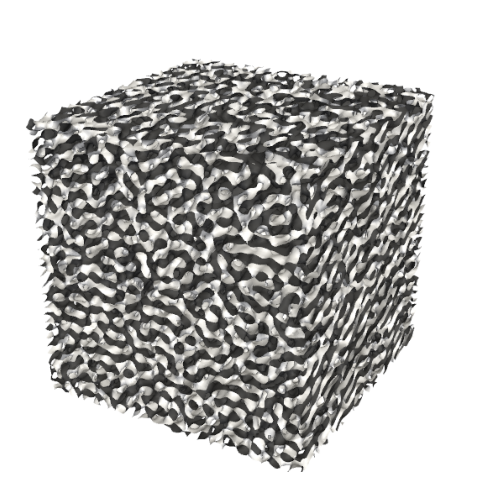

In [15]:
from PIL import Image
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

img = np.asarray(Image.open(filename))[25:575,25:575,:]
ax.imshow(img)
ax.axis('off')

## Scattering function

In [7]:
def scatter_grid(rho, alpha, qq, scale=1, box_size=2):
    """
    Calculates the scattering function S(Q) for a grid density using Fourier transform.

    The function performs the following steps:

    1. Upsamples the grid density by a specified scaling factor using ndimage.zoom().
    2. Clips the upscaled density values to a binary representation (0 or 1) 
       based on the threshold alpha.
    3. Computes the FFT of the binary grid density.
    4. Calculates the scattering function S_q_lmn by squaring the absolute value of the FFT and 
       normalizing by (N/2)^2, where N is the total number of grid points.
    5. Reduces the S_q_lmn
    
    Args:
        rho (ndarray): Grid density.
        alpha (float): Threshold value for density clipping.
        qq (ndarray): Array of Q values.
        scale (int, optional): Scaling factor for upsampling the grid data. Default is 1.
        box_size (float, optional): Size of the simulation box. Default is 2.
    
    Returns:
        ndarray: Scattering function S(Q).
    """
    
    n_grid_scale = rho.shape[0] * scale  # Number of grid points along each dimension
    
    N = (n_grid_scale) ** 3  # Number of grid points after scaling
    
    # Upsampling the grid data with ndimage.zoom()
    rho_bi_zoom = ndimage.zoom(rho, scale, order=1)  # Upscale
    rho_bi = np.zeros_like(rho_bi_zoom)  # Density = 0 or 1
    rho_bi[rho_bi_zoom > alpha] = 1  # Clipped to alpha
    
    rho_r = rho_bi
    N_ones = np.sum(rho_r)  # Number of ones
    
    rho_q = np.fft.fftn(rho_r.astype(np.float32))  # FFT of the grid density
    S_q_lmn = np.absolute(rho_q) ** 2  # Scattering function in grid points

    # Reduce S_q_lmn
    grid_coord = np.meshgrid(np.arange(n_grid_scale), np.arange(n_grid_scale), np.arange(n_grid_scale))
    dq_grid = 2 * np.pi / box_size  # Q grid spacing
    q_grid = np.sqrt(grid_coord[0] ** 2 + grid_coord[1] ** 2 + grid_coord[2] ** 2) * dq_grid  # Abs Q value on each grid point

    S_q_lmn = S_q_lmn.astype(np.float32)
    q_grid = q_grid.astype(np.float32)

    nq = len(qq)  # Number of grid points
    d_bins = qq[1] - qq[0]  # Grid spacing
    index_q = np.floor(q_grid/d_bins)  # Index to qq of each grid point

    S_q = np.zeros(nq)  # Allocate output S(Q)
    n_S_q = np.zeros(nq)  # Allocate n_S(Q)

    for iq in range(nq):
        if np.sum(index_q == iq) > 0:
            S_q[iq] = np.nanmean(S_q_lmn[index_q == iq])
    
    return S_q / (N_ones) ** 2

In [8]:
n_sample = 10
S_q_list = []
for i in trange(n_sample):
    rho = sample_wave(r_grid,k_mean_z,k_cov,n_wave = 30, kappa=kappa)
    # rho = ball()-0.5

    box_size = 2
    n_grid_scale = 256
    scale = n_grid_scale/rho.shape[0]
    dq = 2*np.pi/box_size
    qq = np.arange(n_grid_scale/2)*dq
    
    S_q_i = scatter_grid(rho,alpha,qq,scale=scale)
    S_q_list.append(S_q_i)
    
S_q = np.mean(np.array(S_q_list),axis=0)

100%|██████████| 10/10 [01:30<00:00,  9.03s/it]


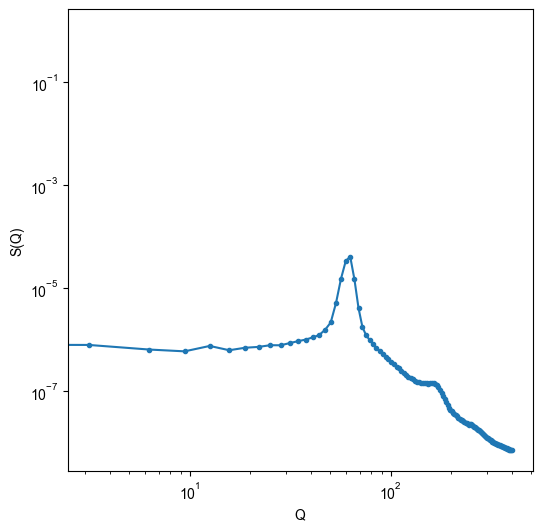

In [9]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

ax.plot(qq[:],S_q[:],'.-')
# ax.plot([4.493,4.493],[1e-9,1],'-k')
# ax.plot([7.725,7.725],[1e-9,1],'-k')
ax.set_xlabel('Q')
ax.set_ylabel('S(Q)')
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,100])
# ax.set_ylim([1e-6,2e0])
plt.show()

In [10]:
# # matplotlib
# # Extract 2D surface mesh from a 3D volume
# # https://stackoverflow.com/questions/6030098
# verts, faces, _, _  = measure.marching_cubes(rho, alpha, spacing=(2/n_grid,2/n_grid,2/n_grid))

# # plotting
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(111, projection='3d')
# ax.view_init(elev=21, azim=-55)
# ax = fig.add_subplot(111, projection='3d')

# ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2], lw=1)
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# plt.show()